In [1]:
import LowLevelFEM as FEM
using LowLevelFEM
using SparseArrays
using Plots

gmsh.initialize()

In [2]:
gmsh.open("DINAMIC_BIG_2.geo");

Info    : Reading 'DINAMIC_BIG_2.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Circle)
Info    : [ 20%] Meshing curve 6 (Circle)
Info    : [ 20%] Meshing curve 7 (Circle)
Info    : [ 20%] Meshing curve 8 (Circle)
Info    : [ 20%] Meshing curve 9 (Circle)
Info    : [ 20%] Meshing curve 10 (Circle)
Info    : [ 30%] Meshing curve 11 (Circle)
Info    : [ 30%] Meshing curve 12 (Circle)
Info    : [ 30%] Meshing curve 13 (Circle)
Info    : [ 30%] Meshing curve 14 (Circle)
Info    : [ 30%] Meshing curve 15 (Circle)
Info    : [ 40%] Meshing curve 16 (Circle)
Info    : [ 40%] Meshing curve 17 (Circle)
Info    : [ 40%] Meshing curve 18 (Circle)
Info    : [ 40%] Meshing curve 19 (Circle)
Info    : [ 40%] Meshing curve 20 (Circle)
Info    : [ 50%] Meshing curve 21 (Circle)
Info    : [ 50%] Meshing curve 22 (Circle)
Info  

In [3]:
#mat = FEM.material("body")
mat1 = FEM.material("Fe", E=1.96e5, ν=0.25, ρ=7.874e-9)
mat2 = FEM.material("Al", E=7e4, ν=0.334, ρ=2.7e-9)
problem = FEM.Problem([mat1, mat2], type="PlaneStress")
#problem = FEM.Problem([mat], type="PlaneStress")

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 216)


LowLevelFEM.Problem("DINAMIC_BIG_2", "PlaneStress", 2, [("Fe", 196000.0, 0.25, 7.874e-9), ("Al", 70000.0, 0.334, 2.7e-9)], 1.0, 15900)

In [4]:
load = FEM.load("right", fx=-1);

In [5]:
K = FEM.stiffnessMatrix(problem);

In [6]:
M = FEM.massMatrix(problem, lumped=true);

In [7]:
f = FEM.loadVector(problem, [load]);

In [8]:
dof = problem.non * problem.dim;

u0 = zeros(dof);
v0 = zeros(dof);


In [9]:
C = spzeros(dof, dof);
C = 1e-8 * K;

In [10]:
Tₘᵢₙ = FEM.smallestPeriodTime(K, M)

3.0927567289999743e-9

In [11]:
n = 10 #3000; # egy lépéssel kevesebb lesz végül az átfedés miatt!

u = zeros(dof, n - 1);
v = zeros(dof, n - 1);
t = zeros(n - 1);

terhelt = 4;
terheletlen = n - terhelt;

u_1, v_1, t_1 = FEM.CDM(K, M, C, f, u0, v0, terhelt * Tₘᵢₙ / π / 1.3, Tₘᵢₙ / π / 1.3);

u_1_kezdo = u_1[:, terhelt];
v_1_kezdo = v_1[:, terhelt];

#display(K)
#display(M)
#display(C)
#display(f)
#display(u_1_kezdo)
#display(v_1_kezdo)
#display(terheletlen)
#display(Tₘᵢₙ)

u_2, v_2, t_2 = FEM.CDM(K, M, C, f * 0, u_1_kezdo, v_1_kezdo, terheletlen * Tₘᵢₙ / π / 1.3, Tₘᵢₙ / π / 1.3);



t_eltolas = t_1[terhelt];
t_2 = t_2 .+ t_eltolas;

u[:, 1:terhelt] = u_1;
u[:, terhelt:n-1] = u_2;

v[:, 1:terhelt] = v_1;
v[:, terhelt:n-1] = v_2;

t[1:terhelt] = t_1;
t[terhelt:n-1] = t_2;

DimensionMismatch: DimensionMismatch: tried to assign 31800×7 array to 31800×6 destination

In [12]:
S = FEM.solveStress(problem, u);

In [13]:
s = FEM.showStressResults(problem, S, "s", t=t, name="σred", visible=true, smooth=false)

1

In [14]:
uvec = FEM.showDoFResults(problem, u, "uvec", t=t, name="u", visible=false)

2

In [15]:
vvec = FEM.showDoFResults(problem, v, "vvec", t=t, name="v", visible=false)

3

In [16]:
#Wi = [(u[:, i] - u[:, i-1])' * (i > 5 ? f * 0 : f) for i in 2:n-1]
Wi = [(u[:, i] - u[:, i-1])' * f for i in 2:4]
W = sum(Wi)

2.5896094238832354e-7

In [17]:
U = u[:, n-1]' * K * u[:, n-1] / 2 + v[:, n-1]' * M * v[:, n-1] / 2
nn = 4    # vagy 5
U = u[:, nn]' * K * u[:, nn] / 2 + v[:, nn]' * M * v[:, nn] / 2

1.160191561918287e-6

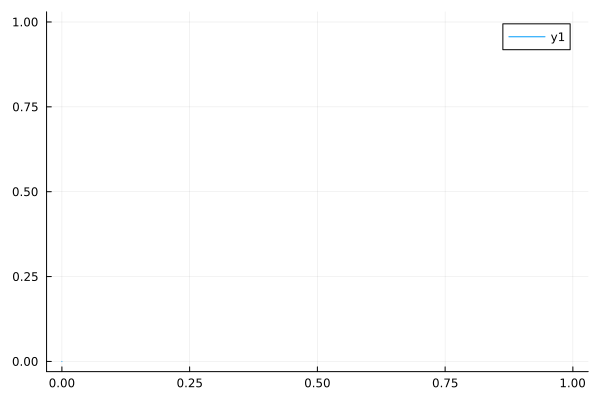

In [18]:
h = 2.5
np = 100
q = 0
X = 7.4999
#display(t)
q_1 = zeros(n - 1, 1);
for j ∈ 2:terhelt+2
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t[j] - t[j-1]
        ss = reshape(gmsh.view.probe(s, X, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X, y, 0, j - 1)[1]
        q += [1, 0, 0]' * ss * vv * ΔA * Δt
    end
    q_1[j, 1] = q
end
#display(q_1)
q
plot(t, q_1)

In [20]:
# Kompenzálás csillapításból
C_E = 0;
for i ∈ 1:terhelt
     C_E += v[:, i]' * C * v[:, i]
end

In [21]:
#display(U)
#display(W)
#display(q)
(U - W) / U * 100

77.6794668321711

In [22]:
(U - q) / U * 100

100.0

In [23]:
(W - q) / W * 100

100.0

In [24]:
((U + C_E) - W) / U * 100

77.6794668321711

In [25]:
(U + C_E - q) / U * 100

100.0

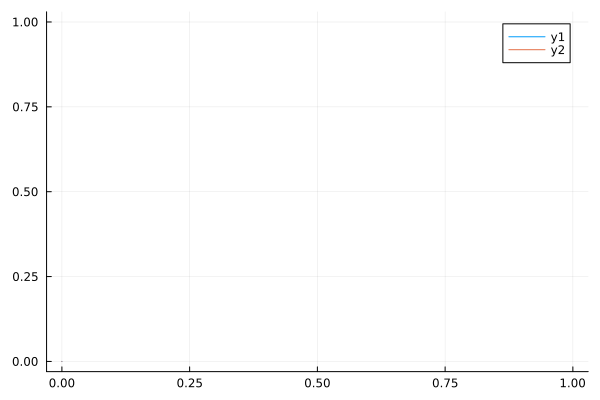

In [27]:
h = 2.5
np = 100
q = 0
X = 5
#display(t)
q_2 = zeros(n - 1, 1);
for j ∈ 2:n-1
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t[j] - t[j-1]
        ss = reshape(gmsh.view.probe(s, X, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X, y, 0, j - 1)[1]
        q += [1, 0, 0]' * ss * vv * ΔA * Δt
    end
    q_2[j, 1] = q
end
#display(q_2)
q
plot!(t, q_2)
# kérdéses, hogy miért nem csökken vissza, amikor a 2. fronton túlhalad a sebesség hullám.

In [28]:
h = 2.5
np = 100
q = 0
X = 0.001
#display(t)
q_3 = zeros(n - 1, 1);
for j ∈ 2:n-1
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t[j] - t[j-1]
        ss = reshape(gmsh.view.probe(s, X, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X, y, 0, j - 1)[1]
        q += [1, 0, 0]' * ss * vv * ΔA * Δt
    end
    q_3[j, 1] = q
end
#display(q_3)
q
plot!(t, q_3, label=["first surface" "second surface" "third surface"], xlabel="t [s]", ylabel="Work [mJ]")
Plots.pdf("surfaces.pdf")

"surfaces.pdf"

In [29]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.12.2
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.6.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XOpenIM() failed
XRequest.18: BadValue 0x0


In [30]:
#gmsh.finalize()